In [4]:
%matplotlib inline
import os
import sys
AbsPath = os.path.abspath("")
sys.path.append(AbsPath+"/../..")
import hmf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from colossus.cosmology import cosmology
from astropy.cosmology import Planck15 as Cosmo_AstroPy
from colossus.halo.concentration import concentration as get_c
from colossus.halo import mass_defs
from colossus.halo.mass_defs import changeMassDefinition as CMD
from colossus.halo.mass_defs import pseudoEvolve as PE
import colossus.halo.mass_adv as massdefs
from scipy.optimize import curve_fit
from scipy.stats import chisquare as ChiSq
from scipy import integrate, trapz
from scipy import interpolate

from Scripts.Plots import SDSS_Plots
from Functions import Functions as F

#macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

HM_Min = 10; HM_Max = 15
HM_Bin = 0.1
Add_SDSS = SDSS_Plots.SDSS_Plots(HM_Min,HM_Max,HM_Bin) #pass this halomass:min, max, and binwidth for amting the SDSS plots

#gets the HMF interpolation function
HMF_fun = F.Make_HMF_Interp()
Cosmo =cosmology.getCurrent()
h = Cosmo.h

SMF_Bin = 0.1
SMF_x = np.arange(9, 12.5, SMF_Bin)

FRACKSKY= 0.1404020420493216


In [5]:
#Abundance Matching Parameters
AbnMtch =\
{\
'UseRP': False,\
'UseBehroozi': False,\
'Behroozi13': False,\
'Lorenzo18':False,\
'UseMoster': True,\
'Moster': False,\
'Moster17': False,\
'UseSF': False,\
'Override_0': False,\
'Override_z': True,\
'z_Evo':True,\
'M10':None,\
'SHMnorm10':None,\
'beta10':None,\
'gamma10':None,\
'M11':1.195,\
'SHMnorm11':-0.0247,\
'beta11':-0.826,\
'gamma11':0.329,\
'Scatter_OR':True,\
'Scatter': None\
}


if True:
    #Cent_only   11.80, 0.032, 1.90, 0.54, 0.13
    AbnMtch['M10'], AbnMtch['SHMnorm10'], AbnMtch['beta10'], AbnMtch['gamma10'], AbnMtch['Scatter'] = 11.95,   0.025,   1.6,   0.52,   0.1
elif False:
    #Sat_Only
    AbnMtch['M10'], AbnMtch['SHMnorm10'], AbnMtch['beta10'], AbnMtch['gamma10'], AbnMtch['Scatter'] = 11.85, 0.035, 1.52, 0.59, 0.16
elif False:
    #Total
    AbnMtch['M10'], AbnMtch['SHMnorm10'], AbnMtch['beta10'], AbnMtch['gamma10'], AbnMtch['Scatter'] = 11.75, 0.034, 1.75, 0.53, 0.13
elif False:
    #Sat only abundance matching to TDYN_factor = 1 usSHMF
    AbnMtch['M10'], AbnMtch['SHMnorm10'], AbnMtch['beta10'], AbnMtch['gamma10'], AbnMtch['Scatter'] = 11.72, 0.036, 1.61, 0.53, 0.13


Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1\
}

#macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

In [6]:
#z=0 Satellites
head = ['M200cSat', 'MvirSat', 'M_parent200c', 'Mparent_bkg', 'Mparent_vir']
FS_Cat = pd.read_csv('./Francesco_Cat/ForPip_z0.0h0.678om0.307_SatParent 0.0200cVirVol500.dat', delim_whitespace=True, names = head)
FS_Sat = np.array(FS_Cat.MvirSat)
#z=0.5 Satellites
head = ['M200cSat', 'MvirSat', 'M_parent200c', 'Mparent_bkg', 'Mparent_vir']
FS_Cat_05 = pd.read_csv('./Francesco_Cat/ForPip_z0.5h0.678om0.307_SatParent 0.5200cVirVol500.dat', delim_whitespace=True, names = head)
FS_Sat_05 = np.array(FS_Cat.MvirSat)
#z=0 Centrals
head_cen = ['M200c', 'M200b', 'Mvir']
FS_Cat_Cen = pd.read_csv('./Francesco_Cat/ForPip_z0.0h0.678om0.307_Cen 0.0200cVir_Vol500.dat', delim_whitespace=True, names = head_cen)
#FS_Cat_Cen = pd.read_csv('./Francesco_Cat/ForPip_z0.1h0.704om0.272_Cen 0.1200cVir_Vol500.dat', delim_whitespace=True, names = head_cen)
FS_Cen = np.array(FS_Cat_Cen.M200c)

In [7]:
usSHMF_Data = np.loadtxt("./Subhalos/Surviving_Subhalosinf.dat")
HaloMassRange_1 = usSHMF_Data[0,1:]
usSHMF_1 = usSHMF_Data[1,1:]
usSHMF_Data = np.loadtxt("./Subhalos/Surviving_Subhalos1.0.dat")
HaloMassRange_tdyn1 = usSHMF_Data[0,1:]
usSHMF_tdyn1 = usSHMF_Data[1,1:]

Checking the HMF against Francescos Catalouge

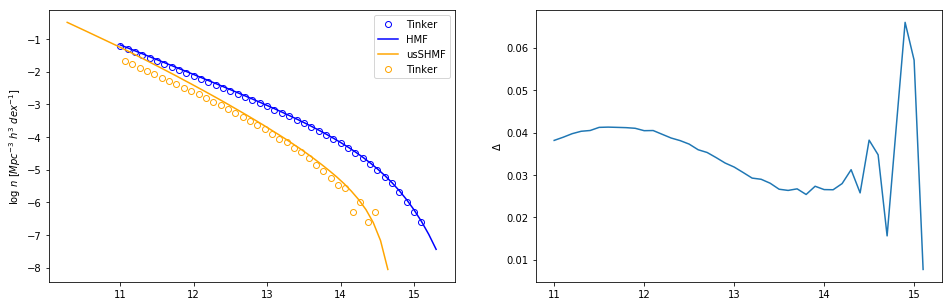

In [10]:
f, SubPlots = plt.subplots(1, 2, figsize = (16,5))


"""
#from Giocoli cat
#Cent
Gic_Cat_Range = np.arange(np.min(FS_Cen), np.max(FS_Cen)+HM_Bin, HM_Bin)
hist, edges = np.histogram(FS_Cen-np.log10(h), bins = Gic_Cat_Range)
hist = np.log10(np.divide(hist, ((500)**3)*HM_Bin))
#Sat
Gic_Cat_Range_Sat = np.arange(np.min(FS_Sat), np.max(FS_Sat)+HM_Bin, HM_Bin)
hist_sat, edges_sat = np.histogram(FS_Sat-np.log10(h), bins = Gic_Cat_Range_Sat)
hist_sat = np.log10(np.divide(hist_sat, ((500)**3)*HM_Bin)) - np.log10(h**3)"""

#from Giocoli cat
#Cent
Gic_Cat_Range = np.arange(np.min(FS_Cen), np.max(FS_Cen)+HM_Bin, HM_Bin)
hist, edges = np.histogram(FS_Cen+np.log10(h), bins = Gic_Cat_Range)
hist = np.log10(np.divide(hist, ((500)**3)*HM_Bin)) - np.log10(h**3)
#Sat
Gic_Cat_Range_Sat = np.arange(np.min(FS_Sat), np.max(FS_Sat)+HM_Bin, HM_Bin)
hist_sat, edges_sat = np.histogram(FS_Sat+np.log10(h), bins = Gic_Cat_Range_Sat)
hist_sat = np.log10(np.divide(hist_sat, ((500)**3)*HM_Bin)) - np.log10(h**3)

HMF_fit = hmf.fitting_functions.Tinker10
HMF_interp = hmf.MassFunction(Mmin=np.min(FS_Cen), Mmax = np.max(FS_Cen), dlog10m=HM_Bin, hmf_model=HMF_fit, delta_h=200.0, delta_wrt='crit', delta_c=1.686)
HMF_HMF = np.log10(HMF_interp.dndlog10m)
HMF_HMF_m = np.log10(HMF_interp.m)



SubPlots[0].plot(edges[:-1], hist, "bo", fillstyle='none',label = "Tinker")
SubPlots[0].plot(HMF_HMF_m, HMF_HMF, "b-",label = "HMF")
SubPlots[0].plot(np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, HaloMassRange_tdyn1), z=0.1, mdef_in='vir', mdef_out='200c')[0]), np.log10(usSHMF_tdyn1), "-", color = "orange", label = "usSHMF")
SubPlots[0].plot(edges_sat[:-1], hist_sat, "o", color = "orange", fillstyle='none',label = "Tinker")

SubPlots[0].legend()
SubPlots[0].set_ylabel('$\log\ n\ [Mpc^{-3}\ h^3\ dex^{-1}]$')


SubPlots[1].plot(edges[:-1], HMF_HMF-hist)
SubPlots[1].set_ylabel('$\Delta$')


plt.show()

Checking the Subhalo massfunctions: Input, Output, FrancescoCat and Analytic

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


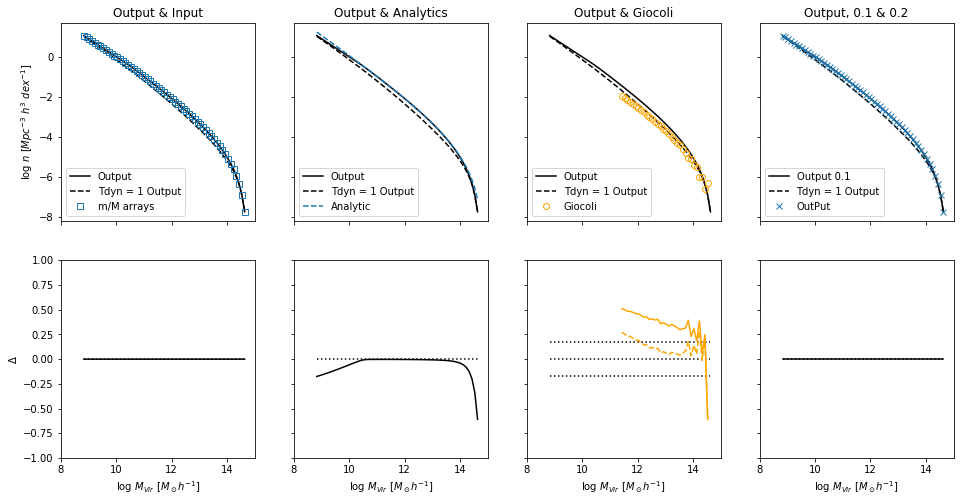

In [6]:
f, SubPlots = plt.subplots(2, 4, figsize = (16,8), sharey = 'row', sharex = True)

def F1(m, Bin, z= 0.0):
    return np.log10(sum([F2(i, m, Bin, z)/Bin for i in np.arange(m, 14.8+Bin, Bin)]))[0]
def F2(M, m, Bin, z):
    return HMF_fun(M, z)*F.dn_dlnX(Unevolved, np.power(10.0, m - M))*(Bin**2) #Mpc^-3 h^3

#from the model
SubPlots[0][0].plot(HaloMassRange_1, np.log10(usSHMF_1), "-k", label = "Output")
SubPlots[0][1].plot(HaloMassRange_1, np.log10(usSHMF_1), "-k", label = "Output")
SubPlots[0][2].plot(HaloMassRange_1, np.log10(usSHMF_1), "-k", label = "Output")
SubPlots[0][3].plot(HaloMassRange_1, np.log10(usSHMF_1), "-k", label = "Output 0.1")

SubPlots[0][0].plot(HaloMassRange_tdyn1, np.log10(usSHMF_tdyn1), "--k", label = "Tdyn = 1 Output")
SubPlots[0][1].plot(HaloMassRange_tdyn1, np.log10(usSHMF_tdyn1), "--k", label = "Tdyn = 1 Output")
SubPlots[0][2].plot(HaloMassRange_tdyn1, np.log10(usSHMF_tdyn1), "--k", label = "Tdyn = 1 Output")
SubPlots[0][3].plot(HaloMassRange_tdyn1, np.log10(usSHMF_tdyn1), "--k", label = "Tdyn = 1 Output")

#From the model setup
SHMF_Entering = np.load("MasterArr/SHMFs_Entering_11.015.00.10.6774.npy")
a, b, c = SHMF_Entering.shape
AnalyticHaloMass_min = 11.0; AnalyticHaloMass_max = 15.0; AnalyticHaloBin = 0.1
AnalyticHaloMass = np.arange(AnalyticHaloMass_min + np.log10(h), AnalyticHaloMass_max + np.log10(h), AnalyticHaloBin)
SatHaloMass = np.arange(AnalyticHaloMass_min-2 + np.log10(h), AnalyticHaloMass_max-0.1 + np.log10(h), AnalyticHaloBin)
HMF = (HMF_fun(AnalyticHaloMass, 0))*AnalyticHaloBin
HMF_c = (np.array([HMF for i in range(c)]).T)

#Units are Mvir h-1
Totals_z = []
for i in range(a):
    Totals_z.append(np.sum(np.multiply(SHMF_Entering[i], HMF_c), axis = 0))
Totals_z = np.array(Totals_z)
uSHMF = np.sum(Totals_z, axis = 0)
SubPlots[0][0].plot(SatHaloMass, np.log10(uSHMF), "s",fillstyle='none',label = "m/M arrays")

#from the model
usSHMF_Data = np.loadtxt("./Subhalos/Surviving_Subhalosinf.dat")
HaloMassRange_2 = usSHMF_Data[0,1:]
usSHMF_2 = usSHMF_Data[1,1:]
SubPlots[0][3].plot(HaloMassRange_2, np.log10(usSHMF_2), "x", label = "OutPut")

#from doing it analytically
Range = HaloMassRange_1
Result = np.array([F1(m, 0.1) for m in Range])#+np.log10(h**3)
SubPlots[0][1].plot(Range, Result, "--", label = "Analytic")

#from Giocoli cat
hist, edges = np.histogram(FS_Sat+np.log10(h), bins = HaloMassRange_1[24:])
hist = np.log10(np.divide(hist, ((500*h)**3)*HM_Bin))[1:]
SubPlots[0][2].plot(edges[2:], hist, "o", color = "orange", fillstyle='none',label = "Giocoli")

#plt.plot(AnalyticHaloMass,np.log10(HMF), label =  "HMF")
plt.xlim(8, 15)
plt.legend()

SubPlots[1][0].set_ylim(-1, 1)

SubPlots[1][0].plot(HaloMassRange_1, np.log10(usSHMF_1) - np.log10(uSHMF), "k")
SubPlots[0][0].set_title("Output & Input")

SubPlots[1][1].plot(HaloMassRange_1, np.log10(usSHMF_1) - Result, "k")
SubPlots[0][1].set_title("Output & Analytics")

SubPlots[1][2].plot(HaloMassRange_1[26:], np.log10(usSHMF_1)[26:] - hist, "-", color = "orange")
SubPlots[1][2].plot(HaloMassRange_tdyn1[26:], np.log10(usSHMF_tdyn1)[26:] - hist, "--", color = "orange")
#SubPlots[1][2].plot(HaloMassRange_tdyn1[26:], np.log10(usSHMF_tdyn1_s)[26:] - hist, ":", color = "orange")
SubPlots[0][2].set_title("Output & Giocoli")

M2 = np.array([np.any(HaloMassRange_2 == i) for i in HaloMassRange_1])
SubPlots[1][3].plot(HaloMassRange_1[M2], np.log10(usSHMF_1[M2]) - np.log10(usSHMF_2), "k")
SubPlots[0][3].set_title("Output, 0.1 & 0.2")



SubPlots[0][0].set_ylabel('$\log\ n\ [Mpc^{-3}\ h^3\ dex^{-1}]$')
SubPlots[1][0].set_ylabel('$\Delta$')
SubPlots[0][0].legend(loc = 3)
SubPlots[0][1].legend(loc = 3)
SubPlots[0][2].legend(loc = 3)
SubPlots[0][3].legend(loc = 3)
SubPlots[1][0].set_xlabel('$\log\ M_{Vir}\ [M_\odot h^{-1}]$')
SubPlots[1][1].set_xlabel('$\log\ M_{Vir}\ [M_\odot h^{-1}]$')
SubPlots[1][2].set_xlabel('$\log\ M_{Vir}\ [M_\odot h^{-1}]$')
SubPlots[1][3].set_xlabel('$\log\ M_{Vir}\ [M_\odot h^{-1}]$')
#SubPlots[1][2].hlines(y=np.log10(h**3), xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), colors = 'k')
#SubPlots[1][2].hlines(y=-np.log10(h**3), xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), colors = 'k')
SubPlots[1][2].hlines(y=np.log10(h), xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), linestyles =  ':', colors = 'k')
SubPlots[1][2].hlines(y=-np.log10(h), xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), linestyles =  ':', colors = 'k')
SubPlots[1][0].hlines(y=0, xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), linestyles =  ':', colors = 'k')
SubPlots[1][1].hlines(y=0, xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), linestyles =  ':', colors = 'k')
SubPlots[1][2].hlines(y=0, xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), linestyles =  ':', colors = 'k')
SubPlots[1][3].hlines(y=0, xmin=np.min(HaloMassRange_1), xmax=np.max(HaloMassRange_1), linestyles =  ':', colors = 'k')
plt.show()

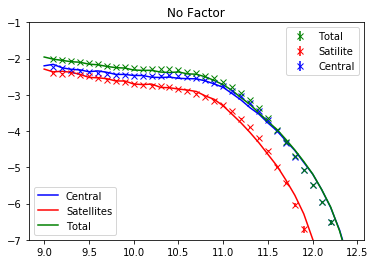

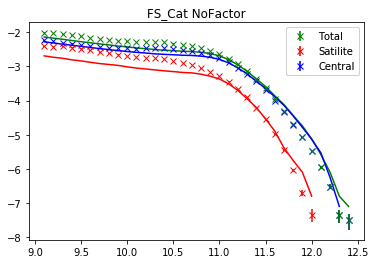

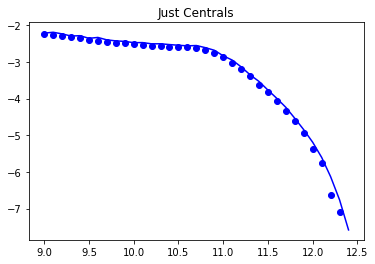

In [9]:
AbnMtch['UseBehroozi'] = False
AbnMtch['Behroozi13'] = False
AbnMtch['UseMoster'] = True
AbnMtch['Moster'] =  False
AbnMtch['Override_z'] = True
Paramaters['AbnMtch'] = AbnMtch
#No Factor
lines_plotted = []
Cent, Sat, Tot, Leg = Add_SDSS.SMF()
#AnalyticHaloMass = np.arange(HM_Min + np.log10(h), HM_Max + np.log10(h), HM_Bin)
AnalyticHaloMass = np.arange(np.min(FS_Cen) + np.log10(h), np.max(FS_Cen) + np.log10(h), HM_Bin)
#Units are Mvir h-1

#Centrals
X, Y = F.DM_to_SM(SMF_x, np.log10(HMF_fun(AnalyticHaloMass, 0)), AnalyticHaloMass, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'b-' , label = "Central")[0])
OTF_Interp_2 = interpolate.interp1d(X, Y)
#Satillites
X, Y = F.DM_to_SM(SMF_x, np.log10(usSHMF_tdyn1), HaloMassRange_tdyn1, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'r-' , label = "Satellites")[0])

#Total
Bin = np.digitize(AnalyticHaloMass[0], HaloMassRange_tdyn1)
Extra_Sat = len(AnalyticHaloMass)-len(usSHMF_tdyn1[Bin:])
Total = np.concatenate((usSHMF_tdyn1[Bin:], np.full(Extra_Sat, np.power(10.0, -300.0)))) + HMF_fun(AnalyticHaloMass, 0)
X, Y = F.DM_to_SM(SMF_x, np.log10(Total), AnalyticHaloMass, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'g-' , label = "Total")[0])


plt.ylim(-7,-1)
plt.legend(handles=lines_plotted, loc = 3)
plt.title("No Factor")
plt.show()


#Catalouges

Cent, Sat, Tot, Leg = Add_SDSS.SMF()

Galaxies = F.DarkMatterToStellarMass(np.concatenate((FS_Cen, FS_Sat)), 0.1, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[1:], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "g-",label = "Total")

Galaxies = F.DarkMatterToStellarMass(FS_Cen, 0.1, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[1:], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "b-",label = "Central")


OTF_Interp = interpolate.interp1d(SMF_MR[1:], SMF_Out)

Galaxies = F.DarkMatterToStellarMass(FS_Sat, 0.1, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[1:], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "r-",label = "Satilite")

plt.title("FS_Cat NoFactor")
plt.show()



Galaxies = F.DarkMatterToStellarMass(FS_Cen, 0, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[:-1], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "bo", fillstyle = None, label = "Central")

X, Y = F.DM_to_SM(SMF_x, np.log10(HMF_fun(AnalyticHaloMass, 0)), AnalyticHaloMass, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'b-' , label = "Central")[0])
OTF_Interp_2 = interpolate.interp1d(X, Y)

plt.title("Just Centrals")
plt.show()

Compare The array francesco sent to the Abn matching I am using

Make a hmf with moster cosmology

Email To moster
Abn Mtch with 13 we find a slight overproduction in the low mass end in the predicted SMF wrt the latest data B16 we use a crude abn with the satilites we do not believe this diffrce is due to sats as cent SMF is much flatter, using your functional form as an input what is your take on this slight overproduction? Cosmology etc... etc...

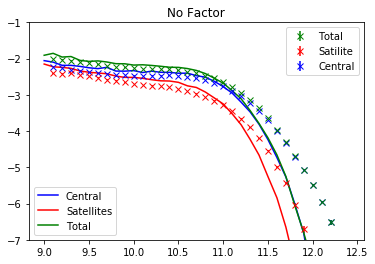

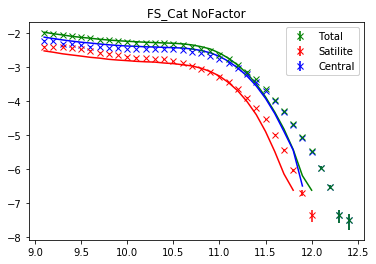

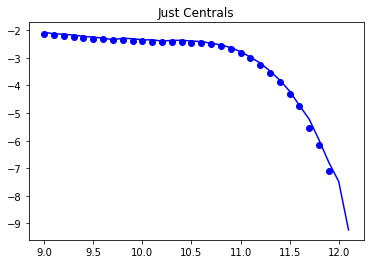

In [8]:
AbnMtch['UseBehroozi'] =  True
AbnMtch['Behroozi13'] =  False
AbnMtch['Lorenzo18'] = True
AbnMtch['UseMoster'] =  False
AbnMtch['Moster'] =  False
Paramaters['AbnMtch'] = AbnMtch
#No Factor
lines_plotted = []
Cent, Sat, Tot, Leg = Add_SDSS.SMF()
#AnalyticHaloMass = np.arange(HM_Min + np.log10(h), HM_Max + np.log10(h), HM_Bin)
AnalyticHaloMass = np.arange(np.min(FS_Cen) + np.log10(h), np.max(FS_Cen) + np.log10(h), HM_Bin)
#Units are Mvir h-1

#Centrals
X, Y = F.DM_to_SM(SMF_x, np.log10(HMF_fun(AnalyticHaloMass, 0)), AnalyticHaloMass, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'b-' , label = "Central")[0])
OTF_Interp_2 = interpolate.interp1d(X, Y)
#Satillites
X, Y = F.DM_to_SM(SMF_x, np.log10(usSHMF_tdyn1), HaloMassRange_tdyn1, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'r-' , label = "Satellites")[0])

#Total
Bin = np.digitize(AnalyticHaloMass[0], HaloMassRange_tdyn1)
Extra_Sat = len(AnalyticHaloMass)-len(usSHMF_tdyn1[Bin:])
Total = np.concatenate((usSHMF_tdyn1[Bin:], np.full(Extra_Sat, np.power(10.0, -300.0)))) + HMF_fun(AnalyticHaloMass, 0)
X, Y = F.DM_to_SM(SMF_x, np.log10(Total), AnalyticHaloMass, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'g-' , label = "Total")[0])


plt.ylim(-7,-1)
plt.legend(handles=lines_plotted, loc = 3)
plt.title("No Factor")
plt.show()


#Catalouges

Cent, Sat, Tot, Leg = Add_SDSS.SMF()

Galaxies = F.DarkMatterToStellarMass(np.concatenate((FS_Cen, FS_Sat)), 0.1, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[1:], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "g-",label = "Total")

Galaxies = F.DarkMatterToStellarMass(FS_Cen, 0.1, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[1:], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "b-",label = "Central")


OTF_Interp = interpolate.interp1d(SMF_MR[1:], SMF_Out)

Galaxies = F.DarkMatterToStellarMass(FS_Sat, 0.1, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[1:], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "r-",label = "Satilite")

plt.title("FS_Cat NoFactor")
plt.show()



Galaxies = F.DarkMatterToStellarMass(FS_Cen, 0, Paramaters, ScatterOn = True)
SMF_Out, SMF_MR = np.histogram(Galaxies, bins = SMF_x)
plt.plot(SMF_MR[:-1], np.log10(np.divide(SMF_Out, ((500)**3)*SMF_Bin)), "bo", fillstyle = None, label = "Central")

X, Y = F.DM_to_SM(SMF_x, np.log10(HMF_fun(AnalyticHaloMass, 0)), AnalyticHaloMass, HM_Bin, SMF_Bin, Paramaters)
lines_plotted.append(plt.plot(X, Y, 'b-' , label = "Central")[0])
OTF_Interp_2 = interpolate.interp1d(X, Y)

plt.title("Just Centrals")
plt.show()